# Pin data, selection, and rotation

This tutorial is here to help make sense of how ARMI stores data on a `Block` for things that exist within the `Block`. For example, the parameter `Block.p.linPowByPin` is a `(N, )` vector of linear pin powers with one entry per pin. You may be wondering

1. Where do those powers exist in the block?
2. What component produces those powers? `linPowByPin` is a `Block` parameter, not a `Component` parameter.
3. What happens when the block is rotated?

By the end of this tutorial, these questions should be answered.

In [1]:
import armi

if not armi.isConfigured():
    armi.configure()


       +===================================================+
       |            _      ____     __  __    ___          |
       |           / \    |  _ \   |  \/  |  |_ _|         |
       |          / _ \   | |_) |  | |\/| |   | |          |
       |         / ___ \  |  _ <   | |  | |   | |          |
       |        /_/   \_\ |_| \_\  |_|  |_|  |___|         |
       |        Advanced  Reactor  Modeling Interface      |
       |                                                   |
       |                    version 0.5.1                  |
       |                                                   |
       +===================================================+


## Single pin demonstration
This tutorial uses the same `anl-afci-177/anl-afci-177.yaml` inputs that exist for the fast reactor example. We'll start by initializing the reactor and grabbing a fuel block, it doens't really matter what one. This reactor has a single fuel pin type which means we won't immediately see interesting behavior, but it makes for easier discussion on the fundamentals. Towards the end, we'll look at demonstrative assembly with multiple fuel pin types per block, a more realistic scenario.

In [2]:
o = armi.init(fName="../../testing/reactors/anl-afci-177/anl-afci-177.yaml")
o.r.core.sortAssemsByRing()

=========== Settings Validation Checks ===========
=========== Case Information ===========
[info] ---------------------  --------------------------------------------------------------------------------
       Case Title:            anl-afci-177
       Case Description:      ANL-AFCI-177 CR 1.0 metal core but with HALEU instead of TRU
       Run Type:              Standard - Operator
       Current User:          aeinstein
       ARMI Location:         C:\Users\aeinstein\codes\armi\armi
       Working Directory:     c:\Users\aeinstein\codes\armi\armi\testing\reactors\anl-afci-177
       Python Interpreter:    3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
       Python Executable:     c:\Users\aeinstein\codes\armi\.venv\armi\Scripts\python.exe
       Master Machine:        TP011870
       Number of Processors:  1
       Date and Time:         Tue Aug 12 15:18:24 2025
       ---------------------  --------------------------------------------------------

In [3]:
from armi.reactor.blocks import HexBlock
from armi.reactor.flags import Flags

In [4]:
import numpy as np

In [5]:
fuelBlock = o.r.core.getFirstBlock(Flags.FUEL)

Next, assign _some_ power profile to the block. We'll pick a 2D function `p(x, y) = x + y` for each pin centered at `(x, y)`. This way, the rotation of the block be visible.

This introduces the first big point: pin-related data assigned as a block parameter **must** be ordered according to `Block.getPinLocations()`. That is the key connection between how data are ordered, where data exist in space, and what components are associated with those data.

In [6]:
def setPinPow(b: HexBlock):
    """Fake a pin power p(x, y) = x + y."""
    pinPow = np.empty(b.getNumPins(), dtype=float)
    for ix, loc in enumerate(b.getPinLocations()):
        x, y, _z = loc.getLocalCoordinates()
        pinPow[ix] = x + y
    b.p.linPowByPin = pinPow

In [7]:
setPinPow(fuelBlock)

In [8]:
from matplotlib import pyplot

To demonstrate this, we'll make a plot of the block-level pin powers by iterating jointly over the locations in `Block.getPinLocations` and scalar pin values in `Block.p.linPowByPin`. It's not immediately useful because the function
above already set that for us. But this will be helpful to show off rotation too.

In [9]:
def plotPinPow(b: HexBlock, **kwargs):
    pinPows = b.p.linPowByPin
    xs: list[float] = []
    ys: list[float] = []
    ps: list[float] = []
    for ix, loc in enumerate(b.getPinLocations()):
        x, y, _z = loc.getLocalCoordinates()
        xs.append(x)
        ys.append(y)
        ps.append(pinPows[ix])
    # finely tuned scatter plot size to make nice images here
    kwargs.setdefault("s", 150)
    return pyplot.scatter(xs, ys, c=ps, **kwargs)

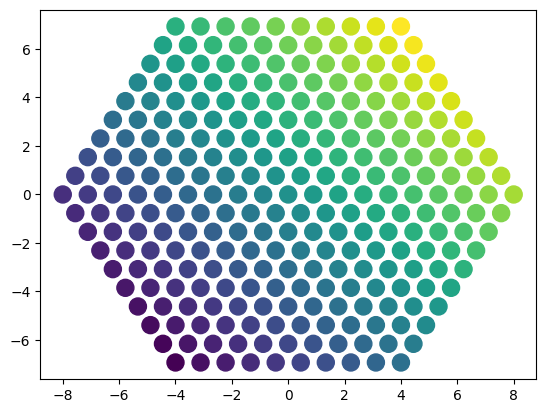

In [10]:
plotPinPow(fuelBlock)

Unsurprisingly, we have a pin power profile that matches our `p(x, y) = x + y`. Pretty!

## Rotation

`HexBlock` objects have an implemented `.rotate` method that supports CCW rotation in 60 degree increments. Before we rotate this block, make copies of the locations and pin power data arrays to compare before and after rotation.

In [11]:
def getPinRingPos(b: HexBlock) -> np.ndarray[tuple[int, int], int]:
    locs = b.getPinLocations()
    allRingPos = [l.getRingPos() for l in locs]
    return np.array(allRingPos)

In [12]:
ringPosBefore = getPinRingPos(fuelBlock)
pinPowerBefore = fuelBlock.p.linPowByPin.copy()

In [13]:
import math

fuelBlock.rotate(math.pi)

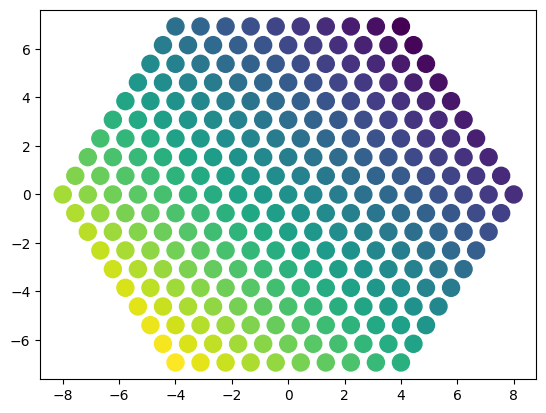

In [14]:
plotPinPow(fuelBlock)

As expected, our pin powers have rotated 180 degrees, with the maxima now in the south west direction. So what changed: the locations of pins or the pin power data array?

This introduces the second key concept: with limited and documented exceptions, `Block` parameter data are **not** modified during rotation, the **locations** of objects within the `Block` are updated. See a discussion in 

If we compare the post-rotation pin powers and pin locations, this is confirmed.

In [15]:
assert (fuelBlock.p.linPowByPin == pinPowerBefore).all()

In [16]:
assert (getPinRingPos(fuelBlock) != ringPosBefore).any()

## Component-level powers
This gets a little trickier to explain because, in our example here, one fuel `Component` occupies the entire fuel lattice. Cases where that may not be the case can follow a similar pattern.

The connection between block level pin powers and the related components is the `Circle.getPinIndices()` method. For a block with `N` pins, a given pin component will have a multiplicity of `M <= N`. `Circle.getPinIndices` will return an `(M, )` vector of integers that translate between the component and block level data.

For the `k`-th pin reflected in `Circle`, with `0 <= k < M`, `kx = Circle.getPinIndices()[k]` is the index in parameters like `Block.p.linPowByPin[kx]` for that particular instance of the pin. And this `k`-th instance of the pin is spatially located in `Block.getPinLocations()[kx]`.

To demonstrate, we'll present the trivial case for a singular fuel `Circle` occupying every lattice site in the grid. Here, we would expect the `.getIndices()` to return what is essentially a `numpy.arange` vector, since every position `[0, N)` is held by this fuel pin.

In [17]:
from armi.reactor.components import Circle

In [18]:
fuelPin: Circle = fuelBlock.getComponent(Flags.FUEL)

In [19]:
fpIndices = fuelPin.getPinIndices()
assert (fpIndices == np.arange(0, fuelPin.getDimension("mult"))).all(), fpIndices

To help illustrate how to map between component data -> block data -> spatial data, let's plot pin power assigned to just this component.

In [20]:
from matplotlib.colors import Normalize


def plotCompPinPow(c: Circle, **kwargs):
    blockLinPowByPin = c.parent.p.linPowByPin
    xs = []
    ys = []
    ps = []
    myIndices = c.getPinIndices()
    for k, loc in enumerate(c.spatialLocator):
        x, y, _z = loc.getLocalCoordinates()
        xs.append(x)
        ys.append(y)
        kx = myIndices[k]
        ps.append(blockLinPowByPin[kx])
    # normalize the color scheme against all the pin powers in the block
    # not just those for this pin
    norm = Normalize(vmin=blockLinPowByPin.min(), vmax=blockLinPowByPin.max())
    kwargs.setdefault("s", 150)
    return pyplot.scatter(xs, ys, c=ps, norm=norm, **kwargs)

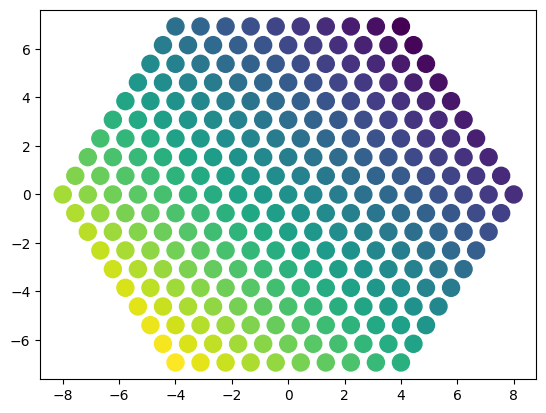

In [21]:
plotCompPinPow(fuelPin)

And one more 60 degree CCW rotation for good measure.

In [22]:
fuelBlock.rotate(math.pi / 3)

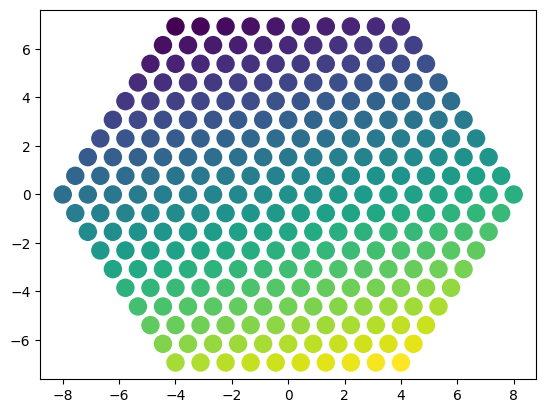

In [23]:
plotCompPinPow(fuelPin)

## Multi-pin example

For the last example, we'll define a semi-covoluted but demonstrative block that has two fuel pin types existing on the same lattice grid. The use of yaml anchors `&`, aliases `*`, and merge keys `<<`. This helps use similar fuel and clad definitions (e.g., material, dimension) but overwrite things like `latticeIDs` and `flags` that we want to be specific to each fuel pin type.

In [24]:
BP_STR = """
blocks:
    fuel: &fuel_block
        grid name: fuel grid
        fuel 1: &fuel_def
            shape: Circle
            # Use void material because we don't need nuclides, just components with flags
            material: Void
            od: 0.68
            Tinput: 25
            Thot: 600
            latticeIDs: [1]
            flags: primary fuel
        clad 1: &clad_def
            shape: Circle
            material: Void
            id: 0.7
            od: 0.71
            Tinput: 600
            Thot: 450
            latticeIDs: [1]
        fuel 2:
            <<: *fuel_def
            latticeIDs: [2]
            flags: secondary fuel
        clad 2:
            <<: *clad_def
            latticeIDs: [2]
        duct:
            shape: Hexagon
            material: Void
            Tinput: 25
            Thot: 450
            ip: 15.3
            op: 16
grids:
    fuel grid:
        geom: hex_corners_up
        symmetry: full
        # Kind of a convoluted map but helps test a lot of edge conditions
        lattice map: |
            - - -  1 1 1 1
              - - 1 1 1 1 1
               - 1 1 2 2 1 1
                1 1 2 1 2 1 1
                 1 1 2 2 1 1
                  1 1 1 1 1
                   1 2 1 1
# Stuff that isn't germane to this example, but necessary to make the blueprints build correctly
assemblies:
    fuel:
        specifier: F
        blocks: [*fuel_block]
        height: [10]
        axial mesh points: [1]
        xs types: [A]
nuclide flags:
"""

In [25]:
from armi.reactor.blueprints import Blueprints
from armi.settings import Settings

In [26]:
def buildMultiPinBlock() -> HexBlock:
    cs = Settings()
    bp = Blueprints.load(BP_STR)
    bp._prepConstruction(cs)
    block = bp.blockDesigns["fuel"].construct(cs, bp, 0, 2, 10, "A", {})
    block.assignPinIndices()
    setPinPow(block)
    return block

In [27]:
multiPinBlock = buildMultiPinBlock()

[info] Will expand HE, NA, AL, SI, V, CR, MN, FE, CO, NI, ZR, NB, MO, W elementals to have natural isotopics
[info] Constructing assembly `fuel`
[info] Block design <fuel block-bol-000 at ExCore XS: A ENV GP: A> is too complicated to verify dimensions. Make sure they are correct!
=========== Verifying Assembly Configurations ===========
[info] Block design <fuel block-bol-000 at ExCore XS: A ENV GP: A> is too complicated to verify dimensions. Make sure they are correct!


Plotting our block-level pin power shows a similar profile to before.

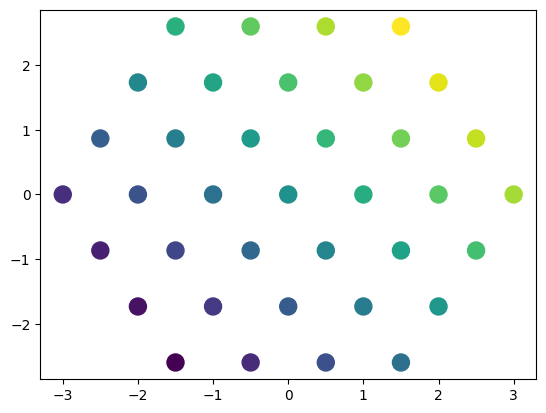

In [28]:
plotPinPow(multiPinBlock)

In [29]:
primaryFuel: Circle = multiPinBlock.getComponent(Flags.PRIMARY)
primaryFuel.getPinIndices()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=uint16)

The ordering is worth discussing. `primaryFuel.getPinIndices()` being sequential `[0, 29]` would imply, at first, that all the `primaryFuel` pins reside in some sequence adjacent to each other. However, the lattice map has `primaryFuel` in the center of the block, and then in the second and third full rings. This ordering is still consistent with `Block.getPinLocations` and is a side-effect of

1. How the hexagonal ascii maps are processed,
2. How pin locations are discovered within a block,
   - For each clad component, extend it's spatial locators

We can see the first "pin" location in our block is not the center, but the north west pin in the block.

In [30]:
assert multiPinBlock.getPinLocations()[0].getRingPos() == (4, 4)

In [31]:
secondaryFuel: Circle = multiPinBlock.getComponent(Flags.SECONDARY)
secondaryFuel.getPinIndices()

array([30, 31, 32, 33, 34, 35, 36], dtype=uint16)

The component level pin plotter shows that we can still collect the same power profile by connecting

1. `Block.getPinLocations`
2. `Block.p.linPowByPin`
3. `Circle.getPinIndices`

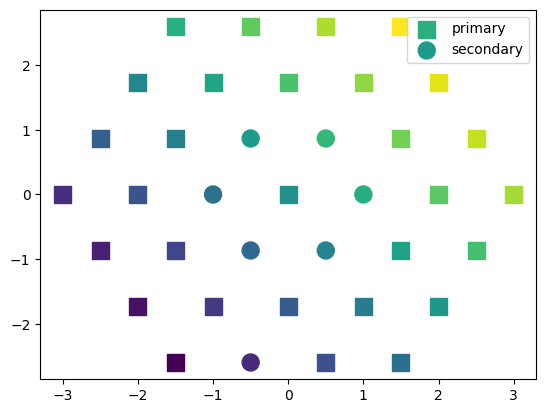

In [32]:
plotCompPinPow(primaryFuel, marker="s", label="primary")
plotCompPinPow(secondaryFuel, marker="o", label="secondary")
pyplot.legend()

Rotate 60 degrees CCW or pi/3

In [33]:
multiPinBlock.rotate(math.pi / 3)

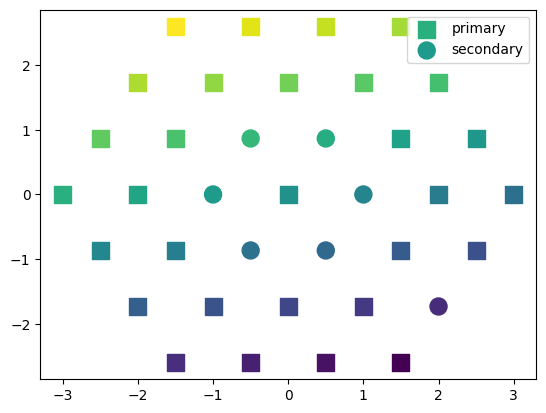

In [34]:
plotCompPinPow(primaryFuel, marker="s", label="primary")
plotCompPinPow(secondaryFuel, marker="o", label="secondary")
pyplot.legend()

## Bringing it all together.

Pin-like parameters are ordered by a pin-index, not strictly a spatial ordering. Therefore they are invariant of rotation; `Block.p.linPowByPin[i]` is the linear power for pin `i`, wherever it may be in the block. 

Without looking into the components, pin `i` is located at `Block.getPinLocations()[i]`. If the block is rotated, the locator `Block.getPinLocations()[i]` will indicate a new location, but it still represents pin `i`.